In [30]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
from descartes import PolygonPatch
from pytorch3d.io import IO, load_obj, save_obj,load_objs_as_meshes
from pytorch3d.structures import join_meshes_as_batch, Meshes, Pointclouds

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from alpha_shapes import Alpha_Shaper, plot_alpha_shape
from torch import Tensor, tensor

import shapely
import os
import trimesh
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [32]:
torch.autograd.set_detect_anomaly(True)

def least_squares(u0, tgt_vtxs):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(tgt_vtxs):
        tgt_vtxs = torch.tensor(tgt_vtxs)
    res = torch.square(u0 - tgt_vtxs.flatten()).sum()
    return res.double()

def least_squares_grad(u0, tgt_vtxs):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
    if torch.is_tensor(tgt_vtxs):
        tgt_vtxs = tgt_vtxs.detach().clone()
    else:
        tgt_vtxs = torch.tensor(tgt_vtxs)
        
    # Ensure that u0 requires gradients
    gradient = 2 * (u0 - tgt_vtxs.flatten())
    return gradient.double()


def calculate_volume(vertices, faces):
    face_vertices = vertices[faces]  # (F, 3, 3)
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    face_volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)
    volume = face_volumes.sum()
    return volume.abs()


def volume_constraint(x, faces, tgt_vol):
    """
    Calculate the volume of a mesh using PyTorch tensors.
    Args:
        vertices_torch: Nx3 tensor of vertex coordinates
        faces: Mx3 array of face indices
    Returns:
        volume: Total volume of the mesh as a PyTorch scalar
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(tgt_vol):
        tgt_vol = torch.tensor(tgt_vol)

    vertices = x.view(-1,3)
    faces = faces.view(-1,3).int()
    volume = calculate_volume(vertices, faces)
    res = volume.abs() - tgt_vol
    return res.double()

def volume_constraint_grad(x, faces):
    if torch.is_tensor(x):
        x = x.detach().clone()
    else:
        x = torch.tensor(x)
    if torch.is_tensor(faces):
        faces = faces.detach().clone()
    else:
        faces = torch.tensor(faces)
    faces = faces.to(dtype=torch.int64)

    vertices_torch = x.view(-1, 3)
    p0 = vertices_torch[faces[:, 0]]  # (F, 3)
    p1 = vertices_torch[faces[:, 1]]  # (F, 3)
    p2 = vertices_torch[faces[:, 2]]  # (F, 3)

    grad_p0 = torch.cross(p1, p2, dim=1) / 6.0
    grad_p1 = torch.cross(p2, p0, dim=1) / 6.0
    grad_p2 = torch.cross(p0, p1, dim=1) / 6.0

    grad_verts = torch.zeros_like(vertices_torch)
    grad_verts.scatter_add_(0, faces[:, 0].unsqueeze(1).expand(-1, 3), grad_p0)
    grad_verts.scatter_add_(0, faces[:, 1].unsqueeze(1).expand(-1, 3), grad_p1)
    grad_verts.scatter_add_(0, faces[:, 2].unsqueeze(1).expand(-1, 3), grad_p2)

    analytical_grad = grad_verts.flatten()
    return analytical_grad 

def padded_to_packed(xs, lengths):
    packed = []
    batch_size = xs.size(0)
    for b in range(batch_size):
        n = lengths[b]
        packed.append(xs[b][:n])
    packed = torch.cat(packed, dim=0)
    return packed

y* = argmin ||X - tgt||^2

target depends on input X

We have mesh points in 3D <-- X
2D edge maps <-- upper level targets

lower level: find Y closest to X that satisfy volume constraint, so Y is being optimised in the lower point

argmin ||X - Y||^2 s.t. vol(Y) = constant

In [33]:
class ConstrainedProjectionNode(EqConstDeclarativeNode):
    """
    Performs a projection of the input points X onto the nearest points Y such that the volume of Y is constant.
    """
    def __init__(self, src: Meshes, tgt: Meshes):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        self.src = src # source meshes (B,)
        # self.tgt = tgt # target meshes (B,)
        self.b = len(src)

    def objective(self, xs: torch.Tensor, y: torch.Tensor, scatter_add=False):
        """
        Calculates sum of squared differences between source and target meshes.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices        
        """
        src_verts = padded_to_packed(xs, self.src.num_verts_per_mesh()).view(-1,3)
        tgt_verts = padded_to_packed(y, self.src.num_verts_per_mesh()).view(-1,3)

        sqr_diffs = torch.square(src_verts - tgt_verts).sum(dim=-1) # (sum(V_i))
        n_batches = len(self.src)
        sse = torch.zeros(n_batches, dtype=sqr_diffs.dtype)
        if scatter_add:
            sse.scatter_add_(0, self.src.verts_packed_to_mesh_idx(), sqr_diffs)
        else:
            n_verts_per_mesh = self.src.num_verts_per_mesh()
            for i in range(n_batches):
                mesh_to_vert = self.src.mesh_to_verts_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_vert[i]
                end = start + n_verts_per_mesh[i]
                sse[i] = sqr_diffs[start:end].sum()  # Sum over all faces
        return sse

    def equality_constraints(self, xs, y, scatter_add=False):
        """
        Enforces volume constraint of projected points
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        y_packed = padded_to_packed(y, self.src.num_verts_per_mesh())
        verts_packed = y_packed.view(-1,3) # (sum(V_i), 3)

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
        
        # Calculate tetrahedron volumes for each face
        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.dtype)
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)    
    
    def solve(self, xs: torch.Tensor):
        """Projects the vertices onto the target mesh vertices across batches.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of vertices in the batched meshes

        Returns:
            results (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        results = torch.zeros((n_batches, num_verts_per_mesh.max(), 3), dtype=torch.double)
        for batch in range(n_batches):
            n_verts = num_verts_per_mesh[batch]
            verts = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()
            faces = self.src[batch].faces_packed().detach().int().cpu().numpy()
            
            # Y = xs[batch][:n_verts].flatten().detach().double().cpu() * 2
            # Y = Y.numpy()
            Y = xs[batch][:n_verts].flatten().detach().double().cpu().numpy() 

            with torch.no_grad():
                src_vtx = self.src[batch].verts_packed().detach()
                src_faces = self.src[batch].faces_packed().detach()
                vol = calculate_volume(src_vtx, src_faces)

            eq_constraint = {
                'type': 'eq',
                'fun' : lambda u: volume_constraint(u, faces, vol).cpu().numpy(),
                'jac' : lambda u: volume_constraint_grad(u, faces).cpu().numpy(),
            }

            res = opt.minimize(
                lambda u: least_squares(u, verts).detach().cpu().numpy(),
                Y,
                method='SLSQP',
                jac=lambda u: least_squares_grad(u, verts).cpu().numpy(),
                constraints=[eq_constraint],
                options={'ftol': 1e-4, 'iprint': 2, 'maxiter': 100}
            )

            if not res.success:
                print("FAILED:", res.message)
            results[batch] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        results = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
        return results,None
    

class ConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


Pseudo code:
- load in the meshes
- inner problem needs access to the vertices, number of meshes, faces, and indexing
- outer problem needs access to projected vertices, number of meshes, and indexing. Also needs projection matrices, and edge maps of renders, so perform edge detection of renders beforehand.

just provide both with the meshes lol

Projection:
Get the indexing correct for the vertices, take the projection of these vertices

In [34]:
# outer problem

def create_padded_tensor(vertices, vert2mesh, max_V, B):
    padded = torch.zeros((B, max_V, 3),device=vertices.device)
    for i in range(B):
        mesh_vertices = vertices[vert2mesh == i]
        num_vertices = mesh_vertices.shape[0]
        padded[i, :num_vertices, :] = mesh_vertices
    return padded

def get_boundary(projected_pts, alpha=5.0):
    # Create a detached copy for Alpha_Shaper
    projected_pts_detached = projected_pts.detach().clone()
    
    # Use the detached copy with Alpha_Shaper
    shaper = Alpha_Shaper(projected_pts_detached)
    alpha_shape = shaper.get_shape(alpha)
    while isinstance(alpha_shape, shapely.MultiPolygon) or isinstance(alpha_shape, shapely.GeometryCollection):
        alpha -= 1
        alpha_shape = shaper.get_shape(alpha)
    boundary = torch.tensor(alpha_shape.exterior.coords.xy, dtype=torch.double)
    
    # Find indices of boundary points
    boundary_indices = torch.where(
        torch.any(torch.isclose(projected_pts_detached[:, None], boundary.T, atol=1e-6).all(dim=-1), dim=1)
    )[0]
    
    # Index back into the original tensor with gradients
    boundary_pts = projected_pts[boundary_indices]
    return boundary_pts

class PyTorchChamferLoss(nn.Module):
    def __init__(self, src: Meshes, tgt: Meshes, projmatrices, edgemap_info):
        super().__init__()
        self.src = src  # (B meshes)
        self.tgt = tgt  # (B meshes)
        self.projmatrices = projmatrices # (P, 3, 4)
        self.edgemaps = edgemap_info[0] # (P, max_Ni, 2)
        self.edgemaps_len = edgemap_info[1] # (P,)
    
    def project_vertices(self, vertices):
        """
        Projects a set of vertices into multiple views using different projection matrices.
        Args:
            vertices: Tensor of shape (N, 3), representing 3D vertex positions.
        Returns:
            Tensor of shape (P, N, 2), containing projected 2D points in each view.
        """
        V = vertices.shape[0]
        projection_matrices = self.projmatrices

        ones = torch.ones((V, 1), dtype=vertices.dtype, device=vertices.device)
        vertices_homogeneous = torch.cat([vertices, ones], dim=1).double()  # Shape: (V, 4)

        # Perform batched matrix multiplication (P, 3, 4) @ (V, 4, 1) -> (P, V, 3)
        projected = torch.einsum("pij,vj->pvi", projection_matrices, vertices_homogeneous)  # (P, V, 3)
        
        projected_cartesian = projected[:, :, :2] / projected[:, :, 2:3]  # (P, V, 2)

        return projected_cartesian

        
    def forward(self, y):
        B, P = len(self.src), self.projmatrices.size(0)
        vertices = y
        # project vertices
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        projected_vertices = [] # (B, P, V, 2)
        for b in range(B):
            end = num_verts_per_mesh[b]
            projverts = self.project_vertices(vertices[b][:end,:])  # Shape: (P, V, 2)
            projected_vertices.append(projverts)  # Store without padding

        # get boundaries
        boundaries = [] 
        boundary_lengths = torch.zeros(B, P)
        for b, batch in enumerate(projected_vertices):
            boundaries_b = []
            for p, projverts in enumerate(batch):
                boundary = get_boundary(projverts)
                boundaries_b.append(boundary)
                boundary_lengths[b,p] = len(boundary)
            padded_boundaries = torch.nn.utils.rnn.pad_sequence(boundaries_b, batch_first=True, padding_value=0.0)
            boundaries.append(padded_boundaries)

        # perform chamfer
        chamfer_loss = torch.zeros(B)
        for b in range(B):
            boundaries_b = boundaries[b].float()
            edgemaps_b = self.edgemaps[b].float()
            res, _ = chamfer_distance(  x=boundaries_b,
                                        y=edgemaps_b,
                                        x_lengths=boundary_lengths[b].long(),
                                        y_lengths=self.edgemaps_len[b].long(),
                                        batch_reduction="mean",
                                        point_reduction="mean")
            chamfer_loss[b] = res.sum()
        return chamfer_loss.double() 



In [35]:
def chamfer_gt(mesh, src:Meshes, tgt:Meshes):
    res,_ = chamfer_distance(x=mesh.detach().float(), 
                             y=tgt.verts_padded().float().detach(),
                             x_lengths=src.num_verts_per_mesh(),
                             y_lengths=tgt.num_verts_per_mesh(),
                             batch_reduction=None,
                             point_reduction="mean")
    # print("Chamfer", res.size())
    return res.tolist() # (B,)


def sse_gt(mesh, src:Meshes, tgt:Meshes):
    sqr_diff = torch.square(mesh - tgt.verts_padded().detach())
    sse = sqr_diff.sum(dim=(1, 2))
    # print("sqrdiff", sqr_diff.size(),"sse", sse.size(), "tgt", tgt.verts_padded().size())
    return sse.tolist() # (B,)


def iou_gt(mesh, src:Meshes, tgt:Meshes,engine='manifold'):
    batch_size = len(mesh)
    ious = []
    gt = tgt.verts_padded()
    for b in range(batch_size):
        num_verts_src = src.num_verts_per_mesh()[b].item()
        num_verts_tgt = tgt.num_verts_per_mesh()[b].item()
        
        mesh_trimesh = trimesh.Trimesh(vertices=mesh[b][:num_verts_src].detach().cpu().numpy(), 
                                       faces=src[b].faces_packed().detach().cpu().numpy())
        gt_trimesh = trimesh.Trimesh(vertices=gt[b][:num_verts_tgt].detach().cpu().numpy(), 
                                     faces=tgt[b].faces_packed().detach().cpu().numpy())
        intersection = mesh_trimesh.intersection(other=gt_trimesh, engine=engine)
        union = mesh_trimesh.union(other=gt_trimesh, engine=engine)
        
        if union.volume == 0:  # Handle edge case
            iou = 0.0
        else:
            iou = intersection.volume / union.volume
        ious.append(iou)
    return ious # (B,)

In [36]:
def plot_projections(projverts, projmats, edgemaps):
    plt.ioff()  # Disable interactive mode

    P, _, _ = projmats.shape
    edge_coords, edge_lens = edgemaps

    # Choose grid layout (e.g., 3x4 for 12)
    cols = 4
    rows = math.ceil(P / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()  # Flatten for easy indexing

    for i in range(P):
        proj_2d_hom = (projmats[i] @ torch.cat([projverts, torch.ones(projverts.shape[0], 1)], dim=1).T).T
        proj_2d = proj_2d_hom[:, :2] / proj_2d_hom[:, 2:3]  # Normalize by depth

        boundary_pts = get_boundary(proj_2d)
        valid_edges = edge_coords[i, :edge_lens[i]]

        ax = axes[i]
        ax.scatter(proj_2d[:, 0], proj_2d[:, 1], c='b', s=8, label="Projected Vertices")
        ax.scatter(valid_edges[:, 0], valid_edges[:, 1], c='r', s=1, label="Edge Coordinates")
        ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], c='g', s=3, label="Boundary Points")

        ax.set_title(f"Projection {i+1}", fontsize=10)
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.axis("equal")
        ax.invert_yaxis()

    # Turn off any unused subplots
    for j in range(P, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=0.5)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()
    plt.close(fig)

def visualise_meshes(srcmesh, tgtmesh):
    vertices = np.asarray(srcmesh.verts_packed())
    faces = np.asarray(srcmesh.faces_packed())

    # Create a Plotly 3D mesh
    fig = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=1,
        color="lightblue"
    )])

    vertices = np.asarray(tgtmesh.verts_packed())
    faces = np.asarray(tgtmesh.faces_packed())

    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.1,
        color="red"
    ))

    # Update layout for better presentation
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X"),
            yaxis=dict(title="Y"),
            zaxis=dict(title="Z"),
        ),
        title="3D Mesh Visualization"
    )

    # Show the figure
    fig.show()
    return fig

def visualise_heatmap(src: Meshes, tgt: Meshes, cmin=None, cmax=None):
    mesh_X = trimesh.Trimesh(vertices=src[0].verts_packed().detach().cpu().numpy(), 
                                faces=src[0].faces_packed().detach().cpu().numpy())
    mesh_Y = trimesh.Trimesh(vertices=tgt[0].verts_packed().detach().cpu().numpy(), 
                                faces=tgt[0].faces_packed().detach().cpu().numpy())

    # Get vertices
    X_vertices = mesh_X.vertices
    Y_tree = trimesh.proximity.ProximityQuery(mesh_Y)

    # For each vertex in X, find closest point on Y
    closest_points, _, _ = Y_tree.on_surface(X_vertices)

    # Compute signed distance based on norm from origin
    X_norms = np.linalg.norm(X_vertices, axis=1)
    Y_norms = np.linalg.norm(closest_points, axis=1)
    signed_dists = X_norms - Y_norms  # positive = further out than Y

    # Normalize or clip for better colormap contrast if needed
    max_val = np.max(np.abs(signed_dists))
    if cmin is None or cmax is None:
        cmin, cmax = -max_val, max_val  # white will now be centered at 0

    # Plot using Plotly
    i, j, k = mesh_X.faces.T
    fig = go.Figure(data=[
        go.Mesh3d(
            x=X_vertices[:, 0],
            y=X_vertices[:, 1],
            z=X_vertices[:, 2],
            i=i, j=j, k=k,
            intensity=signed_dists,
            colorscale='RdBu',
            reversescale=True,
            cmin=cmin,
            cmax=cmax,
            colorbar=dict(title='Signed Distance'),
            showscale=True,
            # flatshading=True,
            lighting=dict(ambient=0.8, diffuse=0.9),
            lightposition=dict(x=100, y=200, z=0),
            opacity=1.0
        )
    ])
    fig.update_layout(
        title='Mesh X Colored by Signed Distance from Mesh Y',
        scene=dict(aspectmode='data')
    )
    fig.show()
    return cmin,cmax



class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [37]:

def outer_problem(src: Meshes, tgt: Meshes, projmats, edgemap_info, n_iters, lr, moment, verbose=True):
    node = ConstrainedProjectionNode(src, tgt)
    verts_init = src.verts_padded() # (B, max Vi, 3)
    verts_init.requires_grad = True
    projverts_init = node.solve(verts_init)
    # apply solve
    projverts_init = ConstrainedProjectionFunction.apply(node, verts_init) # (B, max Vi, 3)

    chamfer_loss = PyTorchChamferLoss(src, tgt, projmats, edgemap_info)

    history = [projverts_init]
    verts = verts_init.clone().detach().requires_grad_(True)

    optimiser = torch.optim.SGD([verts], lr=lr, momentum=moment)
    a,b = edgemap_info
    a,b = a[0], b[0]

    plot_projections(verts.detach().squeeze().double(), projmats, (a,b))
    cmin, cmax = None,None
    min_loss = float("inf")
    best_verts = None
    # verts_prev = None
    for i in range(n_iters):
        optimiser.zero_grad(set_to_none=True)
        projverts = ConstrainedProjectionFunction.apply(node, verts)
        history.append(projverts.detach().clone())
        loss = chamfer_loss(projverts)
        colour = bcolors.FAIL
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_verts = projverts.detach().clone()
            colour = bcolors.OKGREEN
        loss.backward()
        optimiser.step()
        if verbose:
            # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
            # SSE: {(torch.norm(projverts - verts_init)**2).sum()} Chamfer: {chamfer_distance(projverts.float(),verts_init.float())[0].sum()}
            print(f"{i:4d} Loss: {colour}{loss.item():.3f}{bcolors.ENDC} Volume: {calculate_volume(projverts[0], src[0].faces_packed()):.3f}")
            print(f"GT Chamfer: [{', '.join(f'{x:.3f}' for x in chamfer_gt(projverts, src, tgt))}] "
                # f"GT SSE: [{', '.join(f'{x:.3f}' for x in sse_gt(projverts, src, tgt))}] "
                f"GT IoU: [{', '.join(f'{x:.3f}' for x in iou_gt(projverts, src, tgt))}]")
            if i % 10 == 9:
                cmin, cmax = visualise_heatmap(Meshes(verts=projverts.detach(), faces=src[0].faces_packed().unsqueeze(0)), tgt[0], cmin,cmax)
                plot_projections(projverts.detach().squeeze().double(), gt_projmats, gt_edgemap_info)
    return best_verts

In [38]:
from utils import load_renders, load_camera_matrices, get_projmats_and_edgemap_info
import cv2
from cv2.typing import MatLike
from scipy.interpolate import splprep, splev

# Apply Canny edge detection
def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    # edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map

def get_edgemaps(renders, mesh_name, options):
    edgemaps = {}
    edgemaps_len = {}
    if mesh_name in renders:
        views = {}
        views_len = {}
        for num, img in renders[mesh_name].items():
            edges = canny_edge_map(img, options[num])
            if True:
                edge_coords = np.argwhere(edges > 0)
                edge_coords = edge_coords[:, [1,0]]
            else:
                contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                all_subpixel_edges = []
                print("number of contours", len(contours))
                for contour in contours:
                    if len(contour) < 5:
                        continue
                    contour = contour.squeeze()  # Remove single-dim (N,1,2) -> (N,2)
                    x, y = contour[:, 0], contour[:, 1]

                    # Fit a spline to the contour
                    try:
                        tck, u = splprep([x, y], s=1.0)  # s controls smoothing
                        u_fine = np.linspace(0, 1, len(x)*2)  # More points = higher "resolution"
                        x_fine, y_fine = splev(u_fine, tck)

                        subpixel_points = np.vstack((x_fine, y_fine)).T
                        all_subpixel_edges.append(subpixel_points)
                        edge_coords = np.concatenate(all_subpixel_edges)
                    except Exception as e:
                        print(f"Skipping a contour due to error: {e}")
                        continue
            views[num] = torch.tensor(edge_coords)
            views_len[num] = len(edge_coords)
        edgemaps[mesh_name] = views
        edgemaps_len[mesh_name] = views_len
    return edgemaps, edgemaps_len


paths = [os.path.join("../data/meshes/", f"{name}_2.obj") for name in ["sphere", "balloon", "parabola", "rstrawberry"]]
sphere, balloon, parabola, rstrawberry = load_objs_as_meshes(paths)

In [39]:
def plot_vertices(verts_list):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    if not isinstance(verts_list, list):
        x, y, z = verts_list.clone().detach().cpu().squeeze().unbind(1)
        ax.scatter3D(x, z, -y)
    else:
        colors = ['b',  'g', 'r' , 'm', 'c', 'y']  # Define some colors for different sets
        marker_size = 5  # Make points smaller
    
        for i, verts in enumerate(verts_list):
            x, y, z = verts.clone().detach().cpu().squeeze().unbind(1)
            ax.scatter3D(x, z, -y, color=colors[i % len(colors)], s=marker_size, label=f"Set {i+1}")    
    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_aspect("equal")
    ax.view_init(190, 30)
    ax.legend()
    plt.show()


## Urban background

In [ ]:
renders_path = "../data/urban/renders"
renders = load_renders(renders_path)
options = [
    (False, 40, 250),
    (False, 40, 250), # skip, bad one
    (False, 40, 250),
    (False, 10, 300)
]
edgemaps, edgemaps_len = get_edgemaps(renders,options)
matrices_path = "../data/urban/cameras"
matrices = load_camera_matrices(matrices_path)

In [ ]:
print(calculate_volume(sphere.verts_packed(), sphere.faces_packed()), calculate_volume(balloon.verts_packed(), balloon.faces_packed()))

In [ ]:
view_idx = [0,2,3]
tgt = "balloon"
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=50, lr=1e-6,moment=0.5)

In [ ]:
vertices = np.asarray(final_verts.squeeze())
# vertices = np.asarray(balloon.verts_packed())
faces = np.asarray(sphere.faces_packed())

# Create a Plotly 3D mesh
fig = go.Figure(data=[go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=1,
    color="lightblue"
)])

vertices = np.asarray(balloon.verts_packed())
faces = np.asarray(sphere.faces_packed())

fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=0.1,
    color="red"
))

# fig.add_trace(go.Scatter3d(
#     x=vertices[:, 0],
#     y=vertices[:, 1],
#     z=vertices[:, 2],
#     mode='markers',
#     marker=dict(
#         size=4,  # Adjust size of the points
#         color='red',  # Color of the vertices
#         opacity=1
#     )
# ))

# Update layout for better presentation
fig.update_layout(
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    title="3D Mesh Visualization"
)

# Show the figure
fig.show()


In [ ]:
plot_vertices(sphere.verts_packed())
plot_vertices(final_verts)
plot_vertices(balloon.verts_packed())

## Sky background

In [24]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
# edgemaps, edgemaps_len = get_edgemaps(renders,t1=20,t2=150)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)
paths = [os.path.join("../data/meshes/", f"{name}_2.obj") for name in ["sphere"]]
sphere = load_objs_as_meshes(paths)
paths = [os.path.join("../data/meshes/", f"{name}.obj") for name in ["balloon", "parabola", "rstrawberry"]]
balloon, parabola, rstrawberry = load_objs_as_meshes(paths)

In [40]:
view_idx = [0,1,2,3,5,6,7,8,9,10,11]
tgt = "balloon"
options=[
    (True, 80, 700), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (False, 10, 120),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 200, 900), # meh
]
edgemaps, edgemaps_len = get_edgemaps(renders,tgt,options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])

gt_projmats, gt_edgemap_info = get_projmats_and_edgemap_info(list(range(12)), tgt, matrices, edgemaps, edgemaps_len)


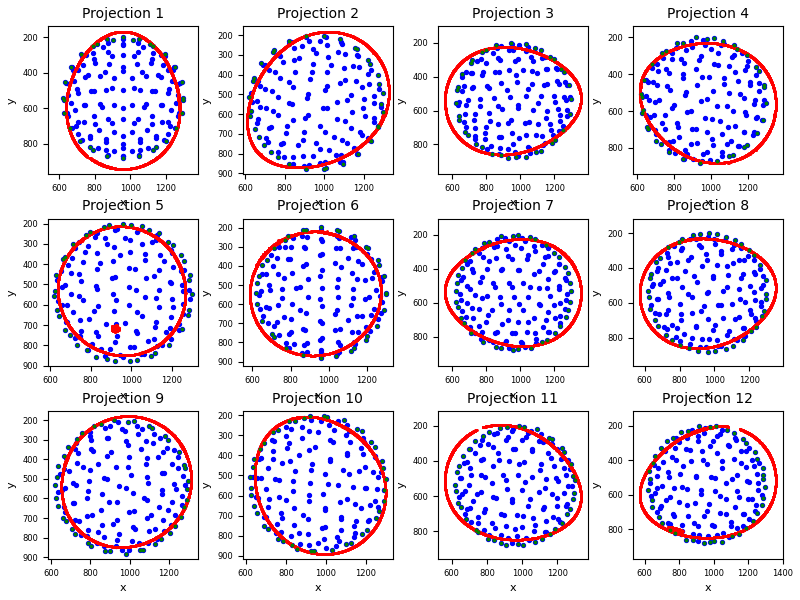

In [41]:
plot_projections(sphere.verts_packed().detach().double(), gt_projmats, gt_edgemap_info)

In [ ]:
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=50, lr=1e-6,moment=0.7)

In [ ]:
from PIL import Image, ImageChops
import trimesh
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from io import BytesIO


def crop_img(img, bg_color=(255, 255, 255), threshold=5):
    bg = Image.new(img.mode, img.size, bg_color)
    diff = ImageChops.difference(img, bg)
    mask = diff.convert('L').point(lambda p: 255 if p > threshold else 0)
    bbox = mask.getbbox()
    return img.crop(bbox) if bbox else img


def scale_and_crop(img, target_w, target_h):
    original_w, original_h = img.size
    scale_factor = max(target_w / original_w, target_h / original_h) + 0.1
    scaled_img = img.resize((int(original_w * scale_factor), int(original_h * scale_factor)), Image.LANCZOS)

    left = (scaled_img.width - target_w) // 2
    upper = (scaled_img.height - target_h) // 2
    return scaled_img.crop((left, upper, left + target_w, upper + target_h))


def compute_signed_distances(src, tgt):
    mesh_X = trimesh.Trimesh(vertices=src[0].verts_packed().cpu().numpy(), faces=src[0].faces_packed().cpu().numpy())
    mesh_Y = trimesh.Trimesh(vertices=tgt[0].verts_packed().cpu().numpy(), faces=tgt[0].faces_packed().cpu().numpy())
    X_vertices = mesh_X.vertices
    Y_tree = trimesh.proximity.ProximityQuery(mesh_Y)
    closest_points, _, _ = Y_tree.on_surface(X_vertices)
    
    X_norms = np.linalg.norm(X_vertices, axis=1)
    Y_norms = np.linalg.norm(closest_points, axis=1)
    return X_norms - Y_norms


def generate_3d_visualization(src, tgt, signed_dists, cmin, cmax):
    mesh_X = trimesh.Trimesh(vertices=src[0].verts_packed().cpu().numpy(), faces=src[0].faces_packed().cpu().numpy())
    i, j, k = mesh_X.faces.T
    return go.Figure(data=[
        go.Mesh3d(
            x=mesh_X.vertices[:, 0],
            y=mesh_X.vertices[:, 1],
            z=mesh_X.vertices[:, 2],
            i=i, j=j, k=k,
            intensity=signed_dists,
            colorscale='RdBu',
            reversescale=True,
            cmin=cmin, cmax=cmax,
            colorbar=dict(title='Signed Distance'),
            showscale=False,
            flatshading=True,
            lighting=dict(ambient=0.8, diffuse=0.7),
            lightposition=dict(x=100, y=200, z=0),
            opacity=1.0
        )
    ])


def capture_camera_views(fig, camera_views, target_w, target_h):
    images = []
    for cam in camera_views:
        fig.update_layout(scene_camera=cam)
        png_bytes = pio.to_image(fig, format='png', width=400, height=400)
        img = Image.open(BytesIO(png_bytes)).convert('RGB')
        img = crop_img(img)
        images.append(scale_and_crop(img, target_w, target_h))
    return images


def create_colorbar(cmin, cmax):
    dummy_fig = go.Figure(data=[go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers',
        marker=dict(size=0.0001, color=[0], colorscale='RdBu', cmin=cmin, cmax=cmax, colorbar=dict(title=' '))
    )])
    dummy_fig.update_layout(scene=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False)),
                            margin=dict(l=0, r=0, t=0, b=0), showlegend=False)
    colorbar_img = Image.open(BytesIO(pio.to_image(dummy_fig, format='png', width=200, height=400)))
    return crop_img(colorbar_img)


def create_final_image(images, colorbar_img, target_w, target_h):
    grid = Image.new('RGB', (2 * target_w, 2 * target_h))
    grid.paste(images[0], (0, 0))
    grid.paste(images[1], (target_w, 0))
    grid.paste(images[2], (0, target_h))
    grid.paste(images[3], (target_w, target_h))

    final_img = Image.new('RGB', (2 * target_w + colorbar_img.width, 2 * target_h), color=(255, 255, 255))
    final_img.paste(grid, (0, 0))
    final_img.paste(colorbar_img, (2 * target_w, (2 * target_h - colorbar_img.height) // 2))
    return final_img


def visualise_heatmap(src, tgt, cmin=None, cmax=None):
    signed_dists = compute_signed_distances(src, tgt)
    if cmin is None or cmax is None:
        max_val = np.max(np.abs(signed_dists))
        cmin, cmax = -max_val, max_val

    fig = generate_3d_visualization(src, tgt, signed_dists, cmin, cmax)
    camera_views = [
        dict(eye=dict(x=1.2, y=1.2, z=1.2)),
        dict(eye=dict(x=-1.2, y=1.2, z=1.2)),
        dict(eye=dict(x=1.2, y=-1.2, z=1.2)),
        dict(eye=dict(x=0.0, y=0.0, z=2.4)),
    ]
    
    images = capture_camera_views(fig, camera_views, 256, 256)
    colorbar_img = create_colorbar(cmin, cmax)
    final_img = create_final_image(images, colorbar_img, 256, 256)

    # Display the final image
    dpi = 100  # You can adjust this if needed
    figsize = (final_img.width / dpi, final_img.height / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0, 0, 1, 1])  # [left, bottom, width, height] in figure coordinates
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(final_img)
    plt.show()

    return cmin, cmax

cmin, cmax = visualise_heatmap(Meshes(verts=final_verts.detach(), faces=sphere.faces_packed().unsqueeze(0)), balloon)
cmin, cmax


In [ ]:
view_idx = [0,1,2,3,5,6,7,8,11]
# view_idx = list(range(12))
tgt = "rstrawberry"
options = [
    (True, 40, 400),
    (False, 5, 250),
    (False, 10, 200),
    (True, 100, 400), # 3, bad
    (False, 5, 200), # 4, meh
    (False, 10, 200),
    (False, 15, 220),
    (False, 15, 250),
    (False, 15, 200),
    (True, 150, 500), # 9, bad
    (False, 0, 320),
    (False, 0, 250)
]
edgemaps, edgemaps_len = get_edgemaps(renders, options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])


plot_projections(balloon.verts_packed().double(), projmats, tgt_edgemap_info)

In [ ]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)

options=[[
    (True, 50, 200), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (True, 40, 600),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 100, 900), # meh
], [
    (True, 40, 400),
    (False, 5, 250),
    (False, 10, 200),
    (True, 100, 400), # 3, bad
    (False, 5, 200), # 4, meh
    (False, 10, 200),
    (False, 15, 220),
    (False, 15, 250),
    (False, 15, 200),
    (True, 150, 500), # 9, bad
    (False, 0, 320),
    (False, 0, 250)
]]

views = [[0,1,2,3,5,6,7,8,9,10,11],
         [0,1,2,3,5,6,7,8,11] 
         ]


def pipeline(src, tgts, tgt_names, views, options):
    T = len(tgts)
    print(T)
    src_mesh = src
    renders_path = "../data/sky/renders"
    renders = load_renders(renders_path)
    matrices_path = "../data/sky/cameras"
    matrices = load_camera_matrices(matrices_path)
    for t in range(T):
        view_idx = views[t]
        tgt_mesh = tgts[t]
        edgemaps, edgemaps_len = get_edgemaps(renders, options[t])
        projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt_names[t], matrices, edgemaps, edgemaps_len)
        batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
        final_verts = outer_problem(src_mesh, tgt_mesh, projmats, batch_tgt_edgemap_info, n_iters=20, lr=5e-6,moment=0.5)
        src_mesh = Meshes(verts=final_verts, faces=tgt_mesh.faces_padded())
        visualise_meshes(src_mesh, tgt_mesh)

In [ ]:
tgts = join_meshes_as_batch([balloon, rstrawberry,parabola])
tgt_names = ["balloon", "rstrawberry","parabola"]
pipeline(sphere, tgts, tgt_names, views, options)

In [47]:
import os
import torch
import numpy as np
import json
from pytorch3d.structures import Meshes
import plotly.graph_objects as go

def save_mesh_as_json(verts, faces, filename):
    data = {
        "vertices": verts.cpu().tolist(),
        "faces": faces.cpu().tolist(),
    }
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)

def project_vertices(verts3d, camera_matrix_path):
    P = torch.tensor(np.load(camera_matrix_path), dtype=verts3d.dtype, device=verts3d.device)
    ones = torch.ones((verts3d.shape[0], 1), dtype=verts3d.dtype, device=verts3d.device)
    verts_h = torch.cat([verts3d, ones], dim=1)
    proj_h = (P @ verts_h.T).T
    proj_2d = proj_h[:, :2] / proj_h[:, 2:]
    return proj_2d.cpu().numpy()

def plot_projverts_scatter2d(projverts, camera_matrix_path, title, save_path=None):
    proj_2d = project_vertices(projverts, camera_matrix_path)
    fig = go.Figure(data=go.Scatter(x=proj_2d[:, 0], y=-proj_2d[:, 1], mode='markers',
                                    marker=dict(size=3), name='Projected verts'))
    fig.update_layout(
        title=title,
        aspectmode="data",
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        showlegend=False,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        width=512, height=512
    )
    fig.show()
    # if save_path:
        # fig.write_json(save_path)
    return fig


def visualise_heatmap(src: Meshes, tgt: Meshes, cmin=None, cmax=None):
    mesh_X = trimesh.Trimesh(vertices=src[0].verts_packed().detach().cpu().numpy(), 
                                faces=src[0].faces_packed().detach().cpu().numpy())
    mesh_Y = trimesh.Trimesh(vertices=tgt[0].verts_packed().detach().cpu().numpy(), 
                                faces=tgt[0].faces_packed().detach().cpu().numpy())

    # Get vertices
    X_vertices = mesh_X.vertices
    Y_tree = trimesh.proximity.ProximityQuery(mesh_Y)

    # For each vertex in X, find closest point on Y
    closest_points, _, _ = Y_tree.on_surface(X_vertices)

    # Compute signed distance based on norm from origin
    X_norms = np.linalg.norm(X_vertices, axis=1)
    Y_norms = np.linalg.norm(closest_points, axis=1)
    signed_dists = X_norms - Y_norms  # positive = further out than Y

    # Normalize or clip for better colormap contrast if needed
    max_val = np.max(np.abs(signed_dists))
    if cmin is None or cmax is None:
        cmin, cmax = -max_val, max_val  # white will now be centered at 0

    # Plot using Plotly
    i, j, k = mesh_X.faces.T
    fig = go.Figure(data=[
        go.Mesh3d(
            x=X_vertices[:, 0],
            y=X_vertices[:, 1],
            z=X_vertices[:, 2],
            i=i, j=j, k=k,
            intensity=signed_dists,
            colorscale='RdBu',
            reversescale=True,
            cmin=cmin,
            cmax=cmax,
            colorbar=dict(title='Signed Distance'),
            showscale=True,
            # flatshading=True,
            lighting=dict(ambient=0.8, diffuse=0.9),
            lightposition=dict(x=100, y=200, z=0),
            opacity=1.0
        )
    ])
    fig.update_layout(
        title='Mesh X Colored by Signed Distance from Mesh Y',
        scene=dict(aspectmode='data')
    )
    fig.show()
    return fig, cmin,cmax

from pathlib import Path

def outer_problem(src: Meshes, tgt: Meshes, projmats, edgemap_info, n_iters, lr, moment, verbose=True):
    camera_path = "/Users/jeffreyliang/Documents/Honours/Blender/blurred/cameras/Cam_Ground_3_P.npy"
    output_dir = Path("vis/heatmaps")
    output_dir.mkdir(parents=True, exist_ok=True)

    node = ConstrainedProjectionNode(src, tgt)
    verts_init = src.verts_padded()
    verts_init.requires_grad = True
    projverts_init = ConstrainedProjectionFunction.apply(node, verts_init)

    chamfer_loss = PyTorchChamferLoss(src, tgt, projmats, edgemap_info)
    history = [projverts_init]
    verts = verts_init.clone().detach().requires_grad_(True)
    optimiser = torch.optim.SGD([verts], lr=lr, momentum=moment)
    a, b = edgemap_info
    a, b = a[0], b[0]

    cmin, cmax = None, None
    min_loss = float("inf")
    best_verts = None

    for i in range(n_iters):
        optimiser.zero_grad(set_to_none=True)
        projverts = ConstrainedProjectionFunction.apply(node, verts)
        history.append(projverts.detach().clone())
        loss = chamfer_loss(projverts)

        if loss.item() < min_loss:
            min_loss = loss.item()
            best_verts = projverts.detach().clone()

        loss.backward()
        optimiser.step()

        if verbose:
            vol_proj = calculate_volume(projverts[0], src[0].faces_packed())
            vol_verts = calculate_volume(verts[0], src[0].faces_packed())
            print(f"{i:4d} Loss: {loss.item():.3f} Volume(projverts): {vol_proj:.3f}, Volume(verts): {vol_verts:.3f}")
            print(f"GT Chamfer: [{', '.join(f'{x:.3f}' for x in chamfer_gt(projverts, src, tgt))}] "
                  f"GT IoU: [{', '.join(f'{x:.3f}' for x in iou_gt(projverts, src, tgt))}]")

        if i % 10 == 9:
            faces = src[0].faces_packed()
            mesh_proj = Meshes(verts=projverts.detach(), faces=faces.unsqueeze(0))
            mesh_verts = Meshes(verts=verts.detach(), faces=faces.unsqueeze(0))

            heatmap_proj, cmin, cmax = visualise_heatmap(mesh_proj, tgt[0], cmin, cmax)
            heatmap_verts, _, _ = visualise_heatmap(mesh_verts, tgt[0], cmin, cmax)

            # heatmap_proj.write_json(output_dir / f"heatmap_proj_{i}.json")
            # heatmap_verts.write_json(output_dir / f"heatmap_verts_{i}.json")

            plot_projverts_scatter2d(projverts.detach()[0], camera_path, f"Step {i} - Projverts", save_path=output_dir / f"projverts_{i}_plot.json")

    return best_verts


In [48]:
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=100, lr=1e-5,moment=0.8)

   0 Loss: 2307.791 Volume(projverts): 4.249, Volume(verts): 4.249
GT Chamfer: [0.034] GT IoU: [0.801]
   1 Loss: 2187.088 Volume(projverts): 4.249, Volume(verts): 4.250
GT Chamfer: [0.033] GT IoU: [0.806]
   2 Loss: 1979.666 Volume(projverts): 4.249, Volume(verts): 4.251
GT Chamfer: [0.031] GT IoU: [0.815]
   3 Loss: 1742.259 Volume(projverts): 4.249, Volume(verts): 4.252
GT Chamfer: [0.030] GT IoU: [0.827]
   4 Loss: 1485.714 Volume(projverts): 4.249, Volume(verts): 4.254
GT Chamfer: [0.028] GT IoU: [0.841]
   5 Loss: 1245.582 Volume(projverts): 4.249, Volume(verts): 4.257
GT Chamfer: [0.026] GT IoU: [0.856]
   6 Loss: 1050.360 Volume(projverts): 4.249, Volume(verts): 4.260
GT Chamfer: [0.025] GT IoU: [0.872]
   7 Loss: 889.629 Volume(projverts): 4.249, Volume(verts): 4.263
GT Chamfer: [0.024] GT IoU: [0.887]
   8 Loss: 769.344 Volume(projverts): 4.249, Volume(verts): 4.267
GT Chamfer: [0.023] GT IoU: [0.902]
   9 Loss: 681.702 Volume(projverts): 4.249, Volume(verts): 4.270
GT Chamfe

ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'aspectmode'

Did you mean "clickmode"?

    Valid properties:
        activeselection
            :class:`plotly.graph_objects.layout.Activeselection`
            instance or dict with compatible properties
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        barcornerradius
            Sets the rounding of bar corners. May be an integer
            number of pixels, or a percentage of bar width (as a
            string ending in %).
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to reduce
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendiciclecolors
            If `true`, the icicle slice colors (whether given by
            `iciclecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to reduce "opacity" to
            see multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            `hiddenlabels`.
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled.
        hoversubplots
            Determines expansion of hover effects to other subplots
            If "single" just the axis pair of the primary point is
            included without overlaying subplots. If "overlaying"
            all subplots using the main axis and occupying the same
            space are included. If "axis", also include stacked
            subplots using the same axis when `hovermode` is set to
            "x", *x unified*, "y" or *y unified*.
        iciclecolorway
            Sets the default icicle slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendiciclecolors`.
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        map
            :class:`plotly.graph_objects.layout.Map` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        minreducedheight
            Minimum height of the plot with margin.automargin
            applied (in px)
        minreducedwidth
            Minimum width of the plot with margin.automargin
            applied (in px)
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newselection
            :class:`plotly.graph_objects.layout.Newselection`
            instance or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        scattergap
            Sets the gap (in plot fraction) between scatter points
            of adjacent location coordinates. Defaults to `bargap`.
        scattermode
            Determines how scatter points at the same location
            coordinate are displayed on the graph. With "group",
            the scatter points are plotted next to one another
            centered around the shared location. With "overlay",
            the scatter points are plotted over one another, you
            might need to reduce "opacity" to see multiple scatter
            points.
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        selections
            A tuple of
            :class:`plotly.graph_objects.layout.Selection`
            instances or dicts with compatible properties
        selectiondefaults
            When used in a template (as
            layout.template.layout.selectiondefaults), sets the
            default property values to use for elements of
            layout.selections
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        smith
            :class:`plotly.graph_objects.layout.Smith` instance or
            dict with compatible properties
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to reduce "opacity" to see
            multiple bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "clickmode"?

Bad property path:
aspectmode
^^^^^^^^^^